# Normalización por Lotes en TensorFlow

En este notebook usaremos TensorFlow para profundizar nuestro entendimiento sobre la normalización por lotes.

## Preliminares

Importemos los paquetes que utilizaremos.

In [1]:
import tensorflow as tf 
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

## Data

Para poder experimentar, necesitaremos datos. ¿Puedes adivinar cuál conjunto de datos usaremos? (Pista: Mira la celda anterior)

In [2]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Clase NeuralNet para Pruebas

Implementaremos una clase que nos permita crear redes neuronales con y sin normalización por lotes de manera sencilla. Su intención no es ser un ejemplo de buenas prácticas en Python, ni tampoco es la mejor arquitectura posible para MNIST. Sólo la usaremos como un mecanismo para mostrar los concepts relacionados con la normalización por lotes.

In [3]:
class NeuralNet(object):
    def __init__(self, initial_weights, activation_function, use_batch_norm):
        self.use_batch_norm = use_batch_norm
        self.name = 'WITH Batch Norm' if self.use_batch_norm else 'WITHOUT Batch Norm'
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        self.training_accuracies = []
        self.build_network(initial_weights, activation_function)
        
    def build_network(self, initial_weights, activation_function):
        self.input_layer = tf.placeholder(tf.float32, (None, initial_weights[0].shape[0]))
        layer_in = self.input_layer
        
        for weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, weights, activation_function)
            
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
        
    def fully_connected(self, layer_in, initial_weights, activation_function=None):
        weights = tf.Variable(initial_weights)
        
        if self.use_batch_norm and activation_function is not None:
            linear_output = tf.matmul(layer_in, weights)
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
            
            return activation_function(batch_normalized_output)
        else:
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            return linear_output if activation_function is None else activation_function(linear_output)
        
    def train(self, session, learning_rate, training_batches, batches_per_sample, save_model_as=None):
        labels = tf.placeholder(tf.float32, (None, 10))
        
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.output_layer))
        
        correct_prediction = tf.equal(tf.arg_max(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        if self.use_batch_norm:
            # If we don't include the update ops as dependencies on the train step, 
            # the tf.layers.batch_normalization layers won't update their population
            # statistics, which will cause the model to fail at inference time.
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            
        for i in tqdm.tqdm(range(training_batches)):
            batch_xs, batch_ys = mnist.train.next_batch(60)
            session.run(train_step, feed_dict={self.input_layer: batch_xs,
                                               labels: batch_ys,
                                               self.is_training: True})
            
            if i % batches_per_sample == 0:
                test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                                 labels: mnist.validation.labels,
                                                                 self.is_training: False})
                self.training_accuracies.append(test_accuracy)
        
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                         labels: mnist.validation.labels,
                                                         self.is_training: False})
        print(f'{self.name}: After training, final accuracy on validation set= {test_accuracy}')
        
        if save_model_as is not None:
            tf.train.Saver().save(session, save_model_as)
            
    def test(self, session, test_training_accuracy=False, include_individual_predictions=False, restore_from=None):
        labels = tf.placeholder(tf.float32, (None, 10))
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        if restore_from:
            tf.train.Saver().restore(session, restore_from)
            
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                         labels: mnist.test.labels,
                                                         self.is_training: test_training_accuracy})
        
        print('-' * 75)
        print(f'{self.name}: Accuracy on full test set = {test_accuracy}')
        
        if include_individual_predictions:
            predictions = []
            correct = 0.
            
            for i in range(200):
                prediction, c = session.run([tf.arg_max(self.output_layer, 1), accuracy],
                                               feed_dict={self.input_layer: [mnist.test.images[i]],
                                                          labels: [mnist.test.labels[i]],
                                                          self.is_training: test_training_accuracy})
                
                correct += c
                predictions.append(prediction[0])
                
            print('200 Predictions: ', predictions)
            print('Accuracy on 200 samples: ', correct / 200)

Hay un par de cosas que debemos tener en cuenta:

  - Las capas con normalización por lotes no contienen _bias_.
  - La matemática de la normalización por lotes es abstraída por `tf.layers.batch_normalization`.
  - Le decimos a `tf.layers.batch_normalization` si la red está entrenando o no. Este es un paso importante, puesto que la normalización por lotes varía dependiendo de si la red se está usando para inferir o para aprender.
  - Aplicamos la normalización **antes** de llamar a la función de activación.
  - `with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS))` es necesario para que la normalización por lotes funcione. Sin ésta instrucción, la operación no se comportará de manera adecuada cuando hagamos inferencias.

## Demos

En esta sección entrenaremos varias redes con y sin normalización por lotes para discutir la diferencia en los resultados. Está basada en [este post](https://r2rt.com/implementing-batch-normalization-in-tensorflow.html]).

La siguiente función dibuja los valores corresponientes a los _accuracies_ reunidos por la red durante el entrenamiento. 

In [4]:
def plot_training_accuracies(*args, **kwargs):
    fix, ax = plt.subplots()
    
    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0, len(nn.training_accuracies) * batches_per_sample, batches_per_sample), nn.training_accuracies, label=nn.name)

    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation accuracy during training')
    ax.legend(loc=4)
    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

Luego, implementaremos una función para crear **dos** redes: Una con normalización por lotes y la otra sin. Posteriormente las entrena y las prueba, y también dibuja sus _accuracies_. La cualidad más importante de esta función es que le pasa el mismo estado inicial (pesos) a cada red, haciendo la comparación entre ambas posible y coherente.

In [5]:
def train_and_test(use_bad_weights, learning_rate, activation_function, training_batches=50000, batches_per_sample=500):
    if use_bad_weights:  # Bad means large standard deviation
        weights = [np.random.normal(size=(784, 100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100, 100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100, 100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100, 10), scale=5.0).astype(np.float32)]
    else:  # Good means small standard deviation
        weights = [np.random.normal(size=(784, 100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100, 100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100, 100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100, 10), scale=0.05).astype(np.float32)]
        
    tf.reset_default_graph()
    
    nn_no_batch_norm = NeuralNet(weights, activation_function, use_batch_norm=False)
    nn_with_batch_norm = NeuralNet(weights, activation_function, use_batch_norm=True)
    
    with tf.Session() as s:
        tf.global_variables_initializer().run()
        
        nn_no_batch_norm.train(s, learning_rate, training_batches, batches_per_sample)
        nn_with_batch_norm.train(s, learning_rate, training_batches, batches_per_sample)
        
        nn_no_batch_norm.test(s)
        nn_with_batch_norm.test(s)
    
    plot_training_accuracies(nn_no_batch_norm, nn_with_batch_norm, batches_per_sample=batches_per_sample)

## Comparando Redes Idénticas con y sin Normalización por Lotes

#### Entrenando redes activadas con ReLU, con pesos razonables y un _learning rate_ igual a 0.01

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `argmax` instead


100%|██████████| 50000/50000 [00:59<00:00, 843.79it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.9782000184059143


100%|██████████| 50000/50000 [01:40<00:00, 499.49it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.9805999994277954
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.9742000102996826
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9796000123023987


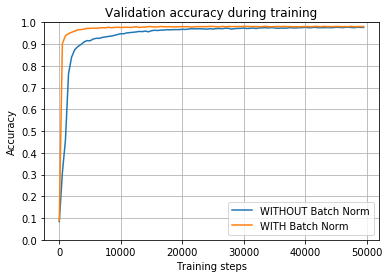

In [6]:
train_and_test(False, 0.01, tf.nn.relu)

Ambas redes entrenan bien y alcanzan _accuracies_ de prueba similares al final. Sin embargo, la red normalizada por lotes converge más rápido, alcanzando su pico de desempeño alrededor de las 15 iteraciones, mientras que la red normal lo alcanza casi al final del entrenamiento.

Con respecto a la velocidad, el cálculo de cada lote toma más tiempo en la red normalizada, pero, de nuevo, converge mucho antes (la única razón por la cual entrenamos ambas redes por el mismo número de iteraciones es para poder graficar sus _accuracies_).

#### Entrenando redes activadas con ReLU, con pesos razonables y un _learning rate_ igual a 0.01, pero sólo por 2000 iteraciones

100%|██████████| 2000/2000 [00:02<00:00, 780.47it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.8507999777793884


100%|██████████| 2000/2000 [00:04<00:00, 452.30it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.9574000239372253
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.8508999943733215
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9516000151634216


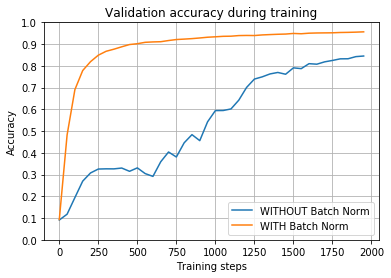

In [7]:
train_and_test(False, 0.01, tf.nn.relu, 2000, 50)

Aquí puedes percatarte de lo que hablamos antes: La normalización por lotes alcanza su máximo desempeño mucho antes que su contraparte sin normalización.

#### Entrenando redes activadas con sigmoid, con pesos razonables y un _learning rate_ igual a 0.01

100%|██████████| 50000/50000 [00:57<00:00, 866.56it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.7605999708175659


100%|██████████| 50000/50000 [01:37<00:00, 513.61it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.974399983882904
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.7551000118255615
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9746999740600586


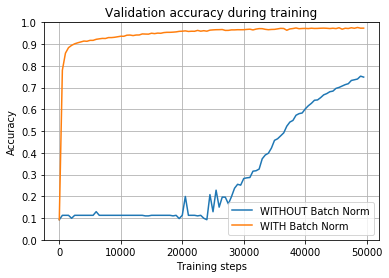

In [8]:
train_and_test(False, 0.01, tf.nn.sigmoid)

Dada la estructura de la red, sigmoid no es una gran opción dado lo mucho que tarda en aprender. A pesar de eso, parece la normalización por lotes no tienen ningún problema con esta función. Chévere, ¿no?

#### Entrenando redes activadas con ReLU, con pesos razonables y un _learning rate_ igual a 1

100%|██████████| 50000/50000 [00:57<00:00, 869.26it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.11259999871253967


100%|██████████| 50000/50000 [01:45<00:00, 475.07it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.9868000149726868
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.11349999904632568
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9846000075340271


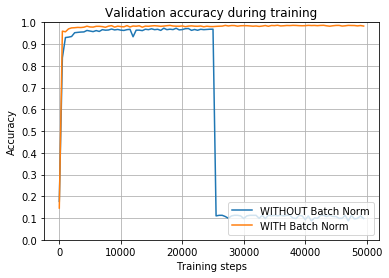

In [9]:
train_and_test(False, 1.0, tf.nn.relu)

En cada libro académico de deep learning que te encuentres verás que el _learning rate_ que escogimos es simplemente absurdo. De hecho, sólo necesitas mirar la curva de la red sin normalización: El comportamiento del gradiente es tan errático que la red jamás aprende, posiblemente a causa de que en algún punto del entrenamiento muchas de sus neuronas murieron.

¡La normalización por lotes puede manejar este _learning rate_ tan algo sin siquiera sudar!

#### Entrenando redes activadas con sigmoid, con pesos razonables y un _learning rate_ igual a 1

100%|██████████| 50000/50000 [00:57<00:00, 867.86it/s] 


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.9783999919891357


100%|██████████| 50000/50000 [01:46<00:00, 471.10it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.982200026512146
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.9747999906539917
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9793999791145325


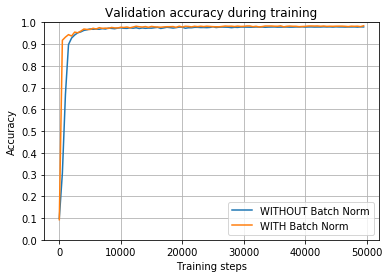

In [10]:
train_and_test(False, 1.0, tf.nn.sigmoid)

Esta vez parece que sigmoid puede manejar mejor el alto valor del _learning rate_. Ambas redes parecen desempeñarse bastante bien. Miremos más de cerca.

#### Entrenando redes activadas con sigmoid, con pesos razonables y un _learning rate_ igual a 1, pero sólo por 2000 iteraciones

100%|██████████| 2000/2000 [00:02<00:00, 740.34it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.925000011920929


100%|██████████| 2000/2000 [00:04<00:00, 431.22it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.9559999704360962
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.9200999736785889
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9531000256538391


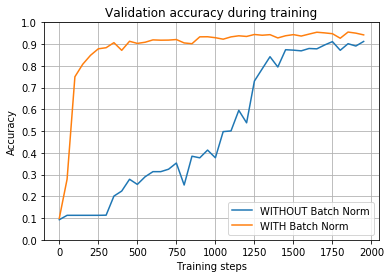

In [12]:
train_and_test(False, 1, tf.nn.sigmoid, 2000, 50)

Aunque ambas lo hacen bien, la versión normalizada alcanza su pico de desempeño más alto que la otra. Esta característica es verdaderamente relevante cuando entrenamos redes neuronales muy grandes.

#### Entrenando redes activadas con ReLU, con pesos razonables y un _learning rate_ igual a 2

100%|██████████| 50000/50000 [00:58<00:00, 859.52it/s] 


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.0957999974489212


100%|██████████| 50000/50000 [01:42<00:00, 486.34it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.982200026512146
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9836000204086304


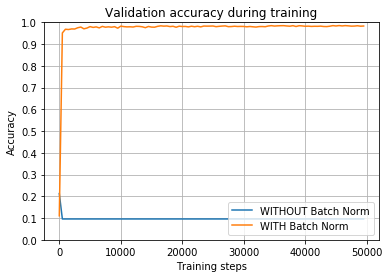

In [13]:
train_and_test(False, 2.0, tf.nn.relu)

La red normal ni siquiera lo intenta esta vez, mientras que la otra entrena sin problemas.

Sabemos que a ReLU no le gustan los _learning rates_ altos. Vemos cómo se las arregla sigmoid con estos mismos hiperparámetros.

#### Entrenando redes activadas con sigmoid, con pesos razonables y un _learning rate_ igual a 2

100%|██████████| 50000/50000 [00:58<00:00, 848.07it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.9807999730110168


100%|██████████| 50000/50000 [01:37<00:00, 510.74it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.9815999865531921
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.9753999710083008
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9793999791145325


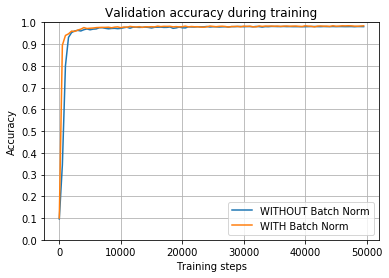

In [14]:
train_and_test(False, 2.0, tf.nn.sigmoid)

Mismo resultado que cuando usamos un _learning rate_ igual a 1. De nuevo, miremos más de cerca.

#### Entrenando redes activadas con sigmoid, con pesos razonables y un _learning rate_ igual a 2, pero sólo por 2000 iteraciones

100%|██████████| 2000/2000 [00:02<00:00, 823.72it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.9172000288963318


100%|██████████| 2000/2000 [00:04<00:00, 487.10it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.9571999907493591
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.9111999869346619
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.9544000029563904


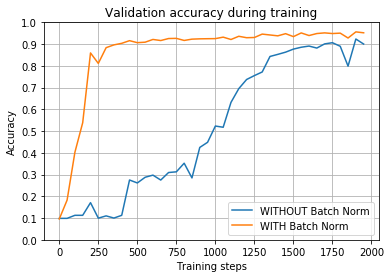

In [15]:
train_and_test(False, 1, tf.nn.sigmoid, 2000, 50)

Same thing: Batch normalization produces better results faster.

#### Entrenando redes activadas con ReLU, con pesos MUY MALOS y un _learning rate_ igual a 0.01

100%|██████████| 50000/50000 [00:59<00:00, 845.20it/s] 


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.0957999974489212


100%|██████████| 50000/50000 [01:39<00:00, 503.96it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.7904000282287598
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.7928000092506409


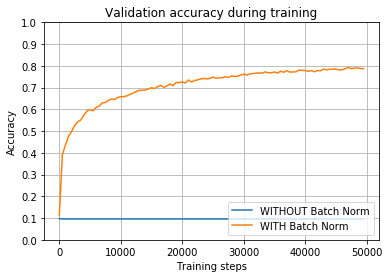

In [16]:
train_and_test(True, 0.01, tf.nn.relu)

We see that the regular network can never recover from the bad starting weights, while the one with batch normalization actually learns pretty well! Of course, the bad choice of initial weights hurts them both permanently, but batch normalization still pulls off a good amount of learning.

#### Entrenando redes activadas con sigmoid, con pesos MUY MALOS y un _learning rate_ igual a 0.01

100%|██████████| 50000/50000 [01:00<00:00, 831.64it/s] 


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.290800005197525


100%|██████████| 50000/50000 [01:37<00:00, 512.70it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.8393999934196472
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.29339998960494995
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.8435999751091003


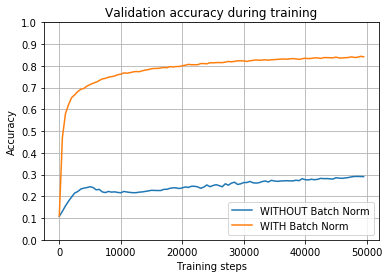

In [17]:
train_and_test(True, 0.01, tf.nn.sigmoid)

Using sigmoid works better for the regular network, but, still after a long number of iterations, it hasn't learnt practically anything, while batch norm still produces decent results.

#### Entrenando redes activadas con ReLU, con pesos MUY MALOS y un _learning rate_ igual a 1

100%|██████████| 50000/50000 [00:59<00:00, 834.42it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.0957999974489212


100%|██████████| 50000/50000 [01:37<00:00, 515.32it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.09860000014305115
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.10090000182390213


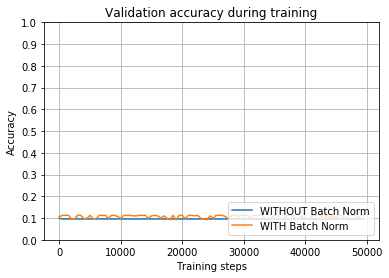

In [18]:
train_and_test(True, 1, tf.nn.relu)

Esta vez resiste el impact de pesos tan malos y de un _learning rate_ tan alto.

#### Entrenando redes activadas con sigmoid, con pesos MUY MALOS y un _learning rate_ igual a 1

100%|██████████| 50000/50000 [00:58<00:00, 856.99it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.8903999924659729


100%|██████████| 50000/50000 [01:38<00:00, 508.27it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.9491999745368958
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.8932999968528748
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.949999988079071


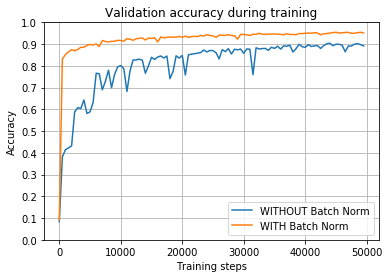

In [19]:
train_and_test(True, 1, tf.nn.sigmoid)

En esta ocasión ambas redes logran unos _accuracies_ de prueba decentes, pero la no normalizada rebota mucho y pasa la mayor parte del entrenamiento estancada y, además, se demora bastante en aprender. Por otro lado, la red normalizada entrena más estable y rápidamente.

#### Entrenando redes activadas con ReLU, con pesos MUY MALOS y un _learning rate_ igual a 2

100%|██████████| 50000/50000 [00:58<00:00, 850.54it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.0957999974489212


100%|██████████| 50000/50000 [01:39<00:00, 501.33it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.09860000014305115
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.10100000351667404


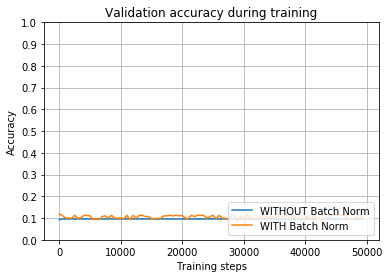

In [20]:
train_and_test(True, 2, tf.nn.relu)

De nuevo, ninguna red puedo lidiar con unos hiperparámetros tan malos.

#### Entrenando redes activadas con sigmoid, con pesos MUY MALOS y un _learning rate_ igual a 2

100%|██████████| 50000/50000 [00:59<00:00, 843.05it/s]


WITHOUT Batch Norm: After training, final accuracy on validation set= 0.9211999773979187


100%|██████████| 50000/50000 [01:39<00:00, 502.57it/s]


WITH Batch Norm: After training, final accuracy on validation set= 0.965399980545044
---------------------------------------------------------------------------
WITHOUT Batch Norm: Accuracy on full test set = 0.9158999919891357
---------------------------------------------------------------------------
WITH Batch Norm: Accuracy on full test set = 0.958899974822998


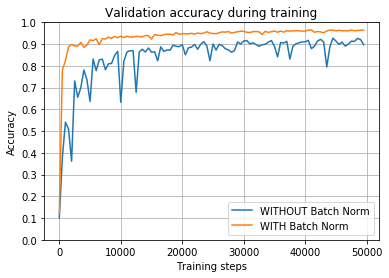

In [22]:
train_and_test(True, 2, tf.nn.sigmoid)

Como era de esperar, sigmoid es más robusta ante malos pesos y un _learning rate_ muy alto, pero aún así, su comportamiento es errático y tiende a quedarse estancada con facilidad. Inclusive en esta instancia la normalización por lotes lo hace mejor.

## La Normalización por Lotes NO ES la Panacea

Como viste anteriormente, la normalización por lotes añade un buen puñado de robustez, pero ello no significa bajo ningún concepto que es sirve como sustituta de una red bien pensada y diseñada. No puedes simplemente crear cualquier cosa y esperar que la normalización por lotes resuelva.

No obstante, es una herramienta muy útil que siempre debiese estar en nuestro arsenal como  practicantes de _deep learning_.